In [1]:
import numpy as np 
from scipy.stats import norm

In [2]:
# Equations
beta_dist = norm(-3, 0.2)
gamma_dist = norm(10, 0.1)
delta_dist = norm(10, 0.1)
epsilon_dist = norm(5, 0.2)
sigma_a_dist = norm(0, 0.3)
sigma_b_dist = norm(0, 0.2)


def a_equation(b, c):
    return beta_dist.rvs() * b + gamma_dist.rvs() * c + sigma_a_dist.rvs()

def b_equation(d, e):
    return delta_dist.rvs() * d + epsilon_dist.rvs() * e + sigma_b_dist.rvs()

In [3]:
cc = norm().rvs(1000)
dd = norm(-10, 1).rvs(1000)
ee = norm(10, 1).rvs(1000)

bb = b_equation(dd, ee)
aa = a_equation(bb, cc)

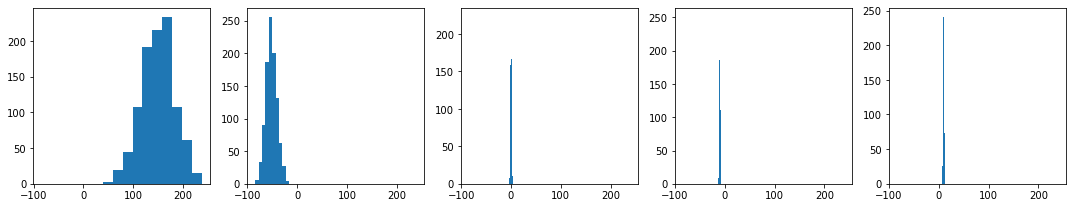

In [4]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(15, 3), ncols=5, sharex=True)

for var, ax in zip([aa, bb, cc, dd, ee], axes.flatten()):
    ax.hist(var)

plt.tight_layout()

In [6]:
import pymc as pm

ModuleNotFoundError: No module named 'pymc'